In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import scipy.sparse.linalg as sla
from scipy.linalg import eig
from tqdm import tqdm
import pickle 
from pfapack import pfaffian as pf
from scipy.fft import ifftn
import dask.array as da
import scipy.integrate as integrate
from scipy.integrate import quad

In [3]:
#first of all write real space one and get MLWF through PxP method 
#after that write BdG and understand how to compute topo invariant from there
#can we do Wilson loops? Wilson loops are extracted by the Bloch wavefunctions of the model (eigenfunctions in k space)
#we can't because this is BdG hamiltonian and apparently you have to use winding or chern (not existing in 1D) so 
#basically winding seems to be only way


#saving old H for safety
    N1=((1/np.cosh(G/2))**(4))*(-8*np.cosh(G/2)**(3)-4*np.sinh(G/2)**(2)*np.cos(3*k)+2*(3*np.cosh(G)+1)*np.cos(k))/(8*A) #checked
    N2=(-((1/np.cosh(G/2))**(4))/(4*A))*(4*np.cosh(G/2)**(3)-2*np.sinh(G/2)**(2)*np.cos(3*k)+3*np.cosh(G)*np.cos(k)+np.cos(k)) #checked
    Hm=-np.tanh(G/2)*((1/np.cosh(G/2))**(3)*(np.cosh(G)+4*1j*np.sinh(G/2)*np.sin(k)**(3)+2*np.cos(2*k)-1))/(2*A) #checked
    S1=-0.5*np.cosh(G/2)*((1/np.cosh(G/2))**(4))*np.sin(k)*(-np.cosh(G)*np.cos(2*k)+np.cos(2*k)+2)  #checked
    S2=np.sqrt(2)*np.sqrt(np.cosh(G)+1)*np.tanh(G/2)*((1/np.cosh(G/2))**(3))*np.sin(k)*np.cos(k)*(1+1j*np.sinh(G/2)*np.sin(k))  #checked
    
    
    
    H = np.zeros((4,4), dtype=complex)
    H[0,0]=N1      +eps1+d*np.cos(3*k)
    H[0,1]=Hm      +1j*d*np.sin(3*k)
    H[0,2]=S1
    H[0,3]=S2
    H[1,0]=Hm.conj()    +1j*d*np.sin(3*k)
    H[1,1]=N2      +eps2+d*np.cos(3*k)
    H[1,2]=S2.conj()
    H[1,3]=-S1
    H[2,0]=S1
    H[2,1]=S2
    H[2,2]=-N1      -eps1-d*np.cos(3*k)
    H[2,3]=-Hm      -1j*d*np.sin(3*k)
    H[3,0]=S2.conj()
    H[3,1]=-S1
    H[3,2]=-Hm.conj()          -1j*d*np.sin(3*k)
    H[3,3]=-N2           -eps2-d*np.cos(3*k)
    
    return(H)

IndentationError: unexpected indent (2760039508.py, line 9)

In [6]:
k,A,G=np.pi/6,0.875,0.2635


N1=((1/np.cosh(G/2))**(4))*(-8*np.cosh(G/2)**(3)-4*np.sinh(G/2)**(2)*np.cos(3*k)+2*(3*np.cosh(G)+1)*np.cos(k))/(8*A) #checked
N2=(-((1/np.cosh(G/2))**(4))/(4*A))*(4*np.cosh(G/2)**(3)-2*np.sinh(G/2)**(2)*np.cos(3*k)+3*np.cosh(G)*np.cos(k)+np.cos(k)) #checked
Hm=-np.tanh(G/2)*((1/np.cosh(G/2))**(3)*(np.cosh(G)+4*1j*np.sinh(G/2)*np.sin(k)**(3)+2*np.cos(2*k)-1))/(2*A) #checked
S1=-0.5*np.cosh(G/2)*((1/np.cosh(G/2))**(4))*np.sin(k)*(-np.cosh(G)*np.cos(2*k)+np.cos(2*k)+2)  #checked
S2=np.sqrt(2)*np.sqrt(np.cosh(G)+1)*np.tanh(G/2)*((1/np.cosh(G/2))**(3))*np.sin(k)*np.cos(k)*(1+1j*np.sinh(G/2)*np.sin(k))  #checked





print("N1=",N1,"N2=",N2,"Hm=",Hm,"S1=",S1,"S2=",S2)

N1= -0.1519034536588329 N2= -2.1141155179225284 Hm= (-0.07548147470329514-0.004818490239785586j) S1= -0.48293317722216567 S2= (0.11149663092729029+0.0073661077120277954j)


In [15]:
#Define Hamiltonian, choose random k value, evaluate for A, G and test if PH operator sigmax cross sigmax flips its sign
def Na(a,g):
    return (4*np.exp(g/2)*(1+3*np.exp(2*g)))/((1+np.exp(g))**(4)*a)

def Nb(a,g):
    return (4*np.exp(3*g/2)*(3+np.exp(2*g)))/((1+np.exp(g))**(4)*a)


def H(k,A,G,eps1,eps2,d):
    

    N1=((1/np.cosh(G/2))**(4))*(-8*np.cosh(G/2)**(3)-4*np.sinh(G/2)**(2)*np.cos(3*k)+2*(3*np.cosh(G)+1)*np.cos(k))/(8*A) -eps1+d*np.cos(3*k)#checked
    N2=(-((1/np.cosh(G/2))**(4))/(4*A))*(4*np.cosh(G/2)**(3)-2*np.sinh(G/2)**(2)*np.cos(3*k)+3*np.cosh(G)*np.cos(k)+np.cos(k)) -eps2-d*np.cos(3*k) #checked
    Hm=-np.tanh(G/2)*((1/np.cosh(G/2))**(3)*(np.cosh(G)+4*1j*np.sinh(G/2)*np.sin(k)**(3)+2*np.cos(2*k)-1))/(2*A) -1j*d*np.sin(3*k)#checked
    S1=-0.5*np.cosh(G/2)*((1/np.cosh(G/2))**(4))*np.sin(k)*(-np.cosh(G)*np.cos(2*k)+np.cos(2*k)+2)  #checked
    S2=np.sqrt(2)*np.sqrt(np.cosh(G)+1)*np.tanh(G/2)*((1/np.cosh(G/2))**(3))*np.sin(k)*np.cos(k)*(1+1j*np.sinh(G/2)*np.sin(k))  #checked
    
    
    
    H = np.zeros((4,4), dtype=complex)
    H[0,0]=N1      
    H[0,1]=Hm      #+1j*d*np.sin(3*k)
    H[0,2]=S1
    H[0,3]=S2
    H[1,0]=Hm.conj()#    -1j*d*np.sin(3*k)
    H[1,1]=N2      
    H[1,2]=S2.conj()
    H[1,3]=-S1
    H[2,0]=S1
    H[2,1]=S2
    H[2,2]=-N1      #-eps1-d*np.cos(3*k)
    H[2,3]=-Hm      #-1j*d*np.sin(3*k)
    H[3,0]=S2.conj()
    H[3,1]=-S1
    H[3,2]=-Hm.conj()#          +1j*d*np.sin(3*k)
    H[3,3]=-N2        #   -eps2-d*np.cos(3*k)
    
    return(H)

def magical(k,A,G,eps1,eps2,d):
    #magic Unitary
    U = np.array([[1,1],[1j,-1j]], dtype='complex128')
    U = np.kron(U,np.eye(2))
    magic = (1/2)*(U@U)
    return (magic@H(k,A,G,eps1,eps2,d)@magic.conj().T)[:2, 2:]

id=np.array([[1,0],[0,1]])
sigma_x=np.array([[0,1],[1,0]])
sigma_y=np.array([[0,-1j],[1j,0]])
sigma_z=np.array([[1,0],[0,-1]])



def complex_quadrature(func, a, b, **kwargs):
    def real_func(x):
        return np.real(func(x))
    def imag_func(x):
        return np.imag(func(x))
    real_integral = quad(real_func, a, b,limit=200)
    imag_integral = quad(imag_func, a, b,limit=200)
    return ((real_integral[0] + 1j*imag_integral[0]))

def integrand(k, a, g,eps1,eps2,d):
    k_res=0.001
    inv = (np.linalg.inv(magical(k,a,g,eps1,eps2,d)))
    der = (1/(2*k_res))*(magical(k+k_res,a,g,eps1,eps2,d)-magical(k-k_res,a,g,eps1,eps2,d))
    temp = inv@der
    return np.trace(temp)

In [8]:
N1=((1/np.cosh(G/2))**(4))*(-8*np.cosh(G/2)**(3)-4*np.sinh(G/2)**(2)*np.cos(3*k)+2*(3*np.cosh(G)+1)*np.cos(k))/(8*A) #checked
N2=(-((1/np.cosh(G/2))**(4))/(4*A))*(4*np.cosh(G/2)**(3)-2*np.sinh(G/2)**(2)*np.cos(3*k)+3*np.cosh(G)*np.cos(k)+np.cos(k)) #checked
Hm=-np.tanh(G/2)*((1/np.cosh(G/2))**(3)*(np.cosh(G)+4*1j*np.sinh(G/2)*np.sin(k)**(3)+2*np.cos(2*k)-1))/(2*A) #checked
S1=-0.5*np.cosh(G/2)*((1/np.cosh(G/2))**(4))*np.sin(k)*(-np.cosh(G)*np.cos(2*k)+np.cos(2*k)+2)  #checked
S2=np.sqrt(2)*np.sqrt(np.cosh(G)+1)*np.tanh(G/2)*((1/np.cosh(G/2))**(3))*np.sin(k)*np.cos(k)*(1+1j*np.sinh(G/2)*np.sin(k))  #checked
A,G,k=1,1,0
print(N1,N2,Hm,S1,S2)

-0.1519034536588329 -2.1141155179225284 (-0.07548147470329514-0.004818490239785586j) -0.48293317722216567 (0.11149663092729029+0.0073661077120277954j)


In [9]:
k,G,A=np.pi/3,1.2432,0.243
print(magical(k,A,G,0,0,0))

[[-1.3464899 +0.61189893j  0.27129314-1.46552272j]
 [-0.11008023+0.80072005j -5.51511077-0.61189893j]]


In [22]:
C1 = np.kron(sigma_z,np.eye(2))
C2= np.kron(sigma_x,np.eye(2))
Sub = np.kron(np.eye(2),sigma_y)
C3=C2@C1
eps,d=0.1,0.1
#verify commutation relations 
#time reversal
print('Time reversal C1 is',np.allclose(C1@H(1,2,1,eps,eps,d).conj()@C1,H(-1,2,1,eps,eps,d)))

#PH symmetry
print('PH C2 is',np.allclose(C2@H(0.1,2,1,eps,eps,d).conj()@C2,-H(-0.1,2,1,eps,eps,d)))

#weird chiral
print('Mysterious chiral C3=C2C1 is',np.allclose(C3@H(0.1,2,1,eps,eps,d)@C3,H(0.1,2,1,eps,eps,d)))

#sublattice
print('Sublattice is',np.allclose(Sub@H(0.1,2,1,eps,eps,d)@C3,-H(0.1,2,1,eps,eps,d)))

Time reversal C1 is True
PH C2 is True
Mysterious chiral C3=C2C1 is True
Sublattice is False


In [23]:
np.allclose(H(1,2,1,eps,eps,d).conj(),H(-1,2,1,eps,eps,d))

False

In [12]:
print(np.linalg.inv(Sub))

[[ 1.  0.  0.  0.]
 [-0. -1. -0. -0.]
 [ 0.  0.  1.  0.]
 [-0. -0. -0. -1.]]


In [268]:
#hermiticity check
eps,d=1,1
np.allclose(H(1,1,1,eps,eps,d).conj().T-H(1,1,1,eps,eps,d),0*np.eye(4))

True

In [269]:
#unitarity check (not expected in BdG basis)
np.allclose(H(1,1,1,0,0,0)@H(1,1,1,0,0,0).conj().T,np.eye(4))

False

In [270]:
#verify if U2@C2@U2=sigma_z
U = np.array([[1,1],[1j,-1j]], dtype='complex128')
U = np.kron(U,np.eye(2))
magic = (1/2)*(U@U)
magic@C2@magic.conj().T

array([[0.+0.j, 0.+0.j, 0.-1.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.-1.j],
       [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j]])

In [796]:
#chiral index
k_res=0.001
eps_range = np.arange(-0.5,0.5,0.1)
d_range = np.arange(-0.5,0.5,0.1) 
k_range = np.arange(-np.pi, np.pi, k_res)

#trying original formula 
A1 = np.zeros((len(eps_range),len(d_range)), dtype='c16')
a,g=1,1
for m,eps in enumerate(tqdm(eps_range)):
    
    for n,d in enumerate(d_range):
        
        v=np.zeros(len(k_range),dtype='c16')

        for i,k in enumerate(k_range):
            
            
            inv = (np.linalg.inv(magical(k,a,g,eps,eps,d)))
            der = (1/(2*k_res))*(magical(k+k_res,a,g,eps,eps,d)-magical(k-k_res,a,g,eps,eps,d))
            temp = inv@der
            v[i]= np.trace(temp)
           
        v_tot=(k_res)*(1/(2*np.pi*1j))*np.sum(v,axis=0)  
   
        A1[m,n]=v_tot

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [01:10<00:00,  7.03s/it]


Text(0, 0.5, '$\\delta$')

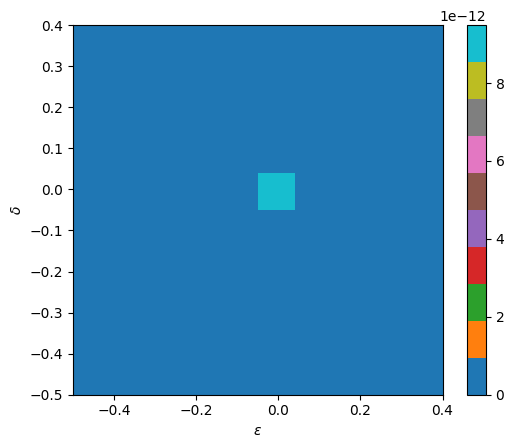

In [797]:
csfont = {'fontname':'Serif'}
x,y = eps_range, d_range 
grid=np.real(np.flipud(A1))

# Create a new figure and add a subplot
fig, ax = plt.subplots()


cax= plt.imshow(grid, extent=(x.min(), x.max(), y.min(), y.max()),
           interpolation='none',cmap='tab10')

fig.colorbar(cax)
#plt.title('eps1=0.5,eps2=0.5,d=0',**csfont)
plt.xlabel(r'$\epsilon$',**csfont)
#plt.ylim(-1.5,1.5)
plt.ylabel(r'$\delta$',**csfont)


In [712]:
eps,d=0,0
a,g=1,1
    
v_tot=complex_quadrature(lambda k: integrand(k,a,g,eps,eps,d),-np.pi,np.pi)
v_tot = (1/(2*np.pi*1j))*v_tot
   
print(v_tot)  

(0.9999999801848299+0j)


In [156]:
A1[50,50] =0 #77064083944.6119-10004053335.21335j

In [367]:
#saving data
with open('scan eps vs delta final,a='+str(a)+'g='+str(g)+',k_res='+str(k_res)+'.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(A1, file)

In [271]:
a,g,eps1,eps2,d=1,1,0,0,-0.2
(1/(2*np.pi*1j))*complex_quadrature(lambda k: integrand(k,a,g,eps1,eps2,d),-np.pi,np.pi)

(0.999999823664872+0j)

In [263]:
#ph index

k_res=0.001
par_res=0.2
eps_range = np.arange(-0.3,0.4,par_res)
d_range = np.arange(-0.3,0.4,par_res) 
k_range = np.arange(-np.pi, np.pi, k_res)
a,g=1,1e-7
#trying original formula 
A2 = np.zeros((len(eps_range),len(d_range)), dtype='c16')

for m,eps in enumerate(tqdm(eps_range)):
    
    for n,d in enumerate(d_range):
        
        v=np.zeros(len(k_range),dtype='c16')

        for i,k in enumerate(k_range):
            
            
            
            inv = (np.linalg.inv(H(k,a,g,eps,-eps,d)))
            der = (1/(2*k_res))*(H(k+k_res,a,g,eps,-eps,d)-H(k-k_res,a,g,eps,-eps,d))
            temp = C1@inv@der
            v[i]= np.trace(temp)
           
        v_tot=(k_res)*(1/(4*np.pi*1j))*np.sum(v,axis=0)  
   
        A2[m,n]=v_tot
    


100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:32<00:00,  5.43s/it]


In [248]:
#integrator

#ph index
k_res=0.001
par_res=0.08
eps_range = np.arange(-0.5,0.6,par_res)
d_range = np.arange(-0.5,0.6,par_res) 
k_range = np.arange(-np.pi, np.pi, k_res)
a_range=np.array([1])
#trying original formula 
A1 = np.zeros((len(eps_range),len(d_range)), dtype='c16')

g=1.5

for i,a in enumerate(a_range):
    
    for m,eps in enumerate(tqdm(eps_range)):
        
        for n,d in enumerate(d_range):
            
            try:
                # Attempt to evaluate the integral
                v_tot = complex_quadrature(lambda k: integrand(k, a, g, eps, -eps, d), -np.pi, np.pi)
    
                # Normalize the result
                v_tot = (1 / (2 * np.pi * 1j)) * v_tot
    
                # Store the result in the matrix
                A1[m, n] = v_tot
    
            except Exception as e:
                # Handle the exception (e.g., matrix is singular, integral diverges)
                print(f"Integration failed for ({eps}, {d}): {e}")
                
                # Assign a specific value to A1[m, n] when integration fails
                A1[m, n] = 10  

    
    # #saving data
    #with open('DEF eps vs delta,eps1=-eps2,a='+str(a)+'g='+str(g)+'par_res='+str(par_res)+'.pkl', 'wb') as file:
    #        
    #    # A new file will be created
    #    pickle.dump(A1, file)   
    #    
    



  0%|                                                                                            | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_732/2681109019.py:59: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  imag_integral = quad(imag_func, a, b,limit=200)
 45%|██████████████████████████████████████▏                                             | 5/11 [00:07<00:09,  1.56s/it]


KeyboardInterrupt: 

Text(0, 0.5, '$\\epsilon$')

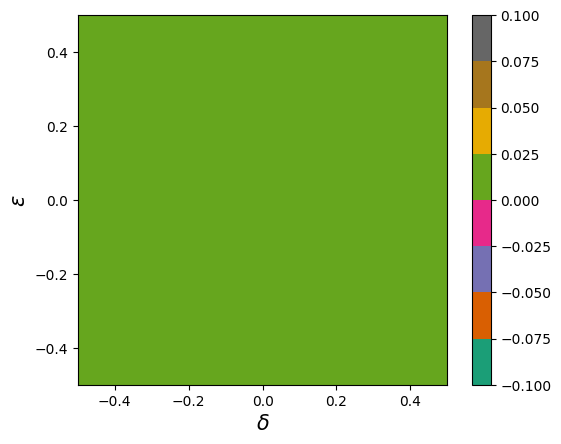

In [264]:
with open('DEF eps vs delta,eps1=-eps2,a=1g=1e-10par_res=0.0025.pkl', 'rb') as file:
    fil = pickle.load(file)


csfont = {'fontname':'Serif'}
x,y = eps_range, d_range 
grid=np.real(np.round(np.flipud(A2)))

# Create a new figure and add a subplot
fig, ax = plt.subplots()


cax= plt.imshow(grid, extent=(x.min(), x.max(), y.min(), y.max()),
           interpolation='none',cmap='Dark2')

fig.colorbar(cax)
#plt.title('eps1=0.5,eps2=0.5,d=0',**csfont)
plt.xlabel(r'$\delta$',**csfont,size=15)
plt.ylim(-0.5,0.5)
plt.xlim(-0.5,0.5)
plt.ylabel(r'$\epsilon$',**csfont,size=15)
#plt.savefig("/mnt/c/Users/azorzat/OneDrive - UvA/Desktop/Plots Paper/SUPERFINAL topo plot a=5 g=0.pdf", bbox_inches='tight')  

In [211]:
A2[np.where(np.abs(A2)>100)]=0

In [82]:
np.flipud(fil)[394,0]=2.000001672673836+0j

In [737]:
a,g,eps,d=1,1,0.1,0.1
v_tot=complex_quadrature(lambda k: integrand(k,a,g,eps,eps,d),-np.pi,np.pi)

v_tot = (1/(2*np.pi*1j))*v_tot
print(v_tot)

(1.4999995686669565+0j)


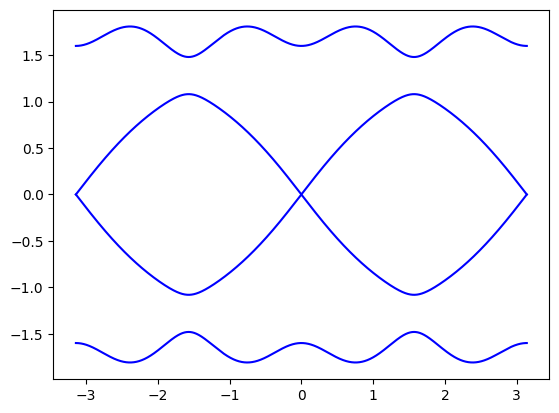

In [153]:
eigenvalues=np.zeros((len(k_range),4))
eps,d=-0.2,-0.2
for i,k in enumerate(k_range):
    #print(i,k)
    #inverse = np.linalg.inv(H(k,1,1,eps,eps,d))
    eigvals,_=np.linalg.eigh(H(k,1,1e-10,eps,eps,d))
    #print(eigvals)
    eigenvalues[i,:]=eigvals#[np.argsort(eigvals)]
    #eigenvectors[i,:]=eigvecs
plt.plot(k_range,eigenvalues,c='b')
#plt.plot(k_range,-eigenvalues)
#plt.xlim(-0.1,0.1)
#plt.ylim(-0.1,0.1)
#print(inverse)

In [823]:
%%time
#plot spectrum of H BdG



from itertools import cycle
from matplotlib.colors import Normalize
csfont = {'fontname':'Serif'}
colormap1 = plt.cm.cool
k_range = np.arange(-np.pi,np.pi,0.001)
delta_range=np.arange(0.3,0.5,0.01)
eigenvalues=np.zeros((len(delta_range),len(k_range),4))
color_cycle1 = cycle(colormap1(np.linspace(0, 1, len(delta_range))))
eps=0.4
th=1e-5
for j,d in enumerate(delta_range):
    for i,k in enumerate(k_range):
        #print(i,k)
        eigvals,_=np.linalg.eigh(H(k,1,1,eps,eps,d))
        #print(eigvals)
        eigenvalues[j,i,:]=eigvals#[np.argsort(eigvals)]
        if (eigvals.any<th):
            print(j,i)         #implement fn to s;pot when eigvals are 0
        #eigenvectors[i,:]=eigvecs
for j in range(len(delta_range)):
    color1=next(color_cycle1)
    #print(j)
    plt.plot(k_range, eigenvalues[j],c=color1)
    #plt.plot(k_range, -eigenvalues[j],c='g')
#plt.xlim(-0.1,0.1)
#plt.ylim(-0.1,0.1)

TypeError: '<' not supported between instances of 'builtin_function_or_method' and 'float'

In [41]:
eps,d=0.3,0.1
eigvals,_=np.linalg.eigh(H(1,1,1,eps,eps,d))

In [42]:
print(eigvals)

[-1.86792952 -0.97508684  0.97508684  1.86792952]


In [674]:
eps,d=0.3,0.1
for i in range(4):
    for j in range(4):
        print('element '+str(i)+str(j)+'=',H(1,1,1,eps,eps,d)[i][j])

element 00= (-0.33239386671293797+0j)
element 01= (0.04660631462290702-0.18602227914353003j)
element 02= (-0.6531897459686514+0j)
element 03= (0.3304668646647564+0.1449052852546782j)
element 10= (0.04660631462290702+0.18602227914353003j)
element 11= (-1.4392424005472992+0j)
element 12= (0.3304668646647564-0.1449052852546782j)
element 13= (0.6531897459686514+0j)
element 20= (-0.6531897459686514+0j)
element 21= (0.3304668646647564+0.1449052852546782j)
element 22= (0.33239386671293797+0j)
element 23= (-0.04660631462290702+0.18602227914353003j)
element 30= (0.3304668646647564-0.1449052852546782j)
element 31= (0.6531897459686514+0j)
element 32= (-0.04660631462290702-0.18602227914353003j)
element 33= (1.4392424005472992+0j)
